In [104]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from sklearn import metrics
import itertools
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS

# Data importation and gathering

In [105]:
fake = pd.read_csv('C:/Users/kkoraibi/Desktop/Python/fakenews/projet/fake.csv')
true = pd.read_csv('C:/Users/kkoraibi/Desktop/Python/fakenews/projet/true.csv')

In [106]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [107]:
fake['label'] = 'fake'
true['label'] = 'true'
# création d'une colonne fake/true nommée label

In [108]:
frames = [fake, true]

In [109]:
# concaténation des deux data frames
df = pd.concat(frames, sort=False)

In [110]:
# random sampling
df = df.sample(frac = 1).reset_index(drop=True)

In [111]:
df.head()

,title,text,subject,date,label
0,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politicsNews,"October 18, 2016",true
1,Ted Cruz Gets Burned By Fox News Host For War...,Ted Cruz got his ass handed to him on Fox News...,News,"January 17, 2016",fake
2,Baghdad relieved by Trump's exclusion of Iraq ...,BAGHDAD (Reuters) - Iraq expressed “deep relie...,politicsNews,"March 6, 2017",true
3,Democratic voter-intimidation cases falter in ...,WASHINGTON (Reuters) - Democrats fell short in...,politicsNews,"November 7, 2016",true
4,Pence Says There Is ‘Too Much Talk’ About Rac...,"While Charlotte, North Carolina faces a state ...",News,"September 22, 2016",fake


In [112]:
# quelques statistiques descriptives
df.describe()

,title,text,subject,date,label
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",fake
freq,14,627,11272,182,23481


### Analyse de la colonne "label" 

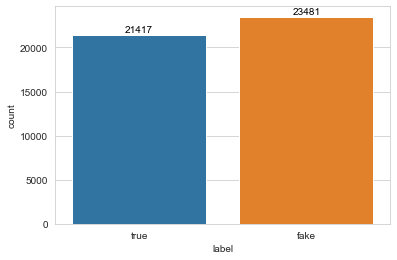

In [113]:
sns.set_style('whitegrid')
ax = sns.countplot(df['label'])
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

The data is balanced.

In [114]:
df2 = df.copy()

In [115]:
df2.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

We notice that politicsNews and politics are the same, we will merge them for a more sophisticated analysis.

In [116]:
df2['subject'] = df2['subject'].replace(['politicsNews'],'politics')

In [117]:
df2.subject.value_counts()

politics           18113
worldnews          10145
News                9050
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

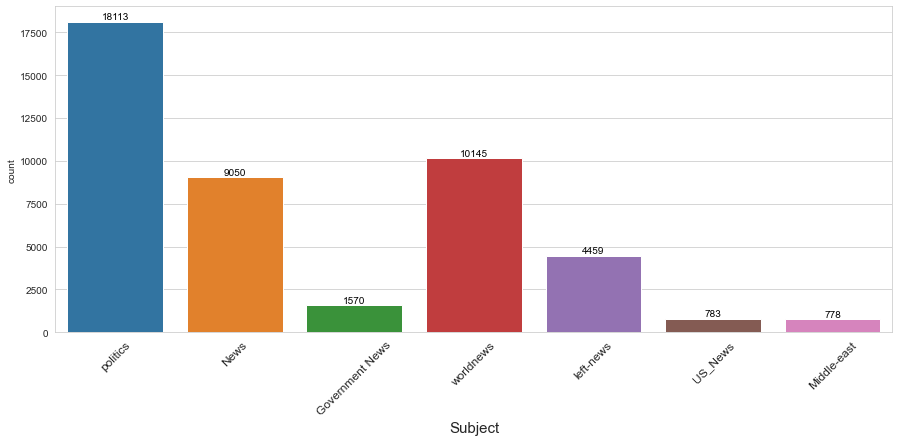

In [118]:
plt.figure(figsize=(15,6))
ax = sns.countplot(df2['subject'])
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.xticks(rotation=45,fontsize=12)
plt.xlabel('Subject',fontsize=15);

In [119]:
df2.date.head()

0     October 18, 2016 
1      January 17, 2016
2        March 6, 2017 
3     November 7, 2016 
4    September 22, 2016
Name: date, dtype: object

In [120]:
# plot en fonction des dates

In [121]:
df2.describe().T

,count,unique,top,freq
title,44898,38729,Factbox: Trump fills top jobs for his administ...,14
text,44898,38646,,627
subject,44898,7,politics,18113
date,44898,2397,"December 20, 2017",182
label,44898,2,fake,23481


We will create a title length column to see if there is a length difference between fake and true news.

In [122]:
df2['length'] = df2['title'].apply(len)

In [123]:
df2.tail()

,title,text,subject,date,label,length
44893,"Trump to nominate Chatterjee, Powelson to FERC...",WASHINGTON (Reuters) - President Donald Trump ...,politics,"May 9, 2017",true,59
44894,Cenk Uygur Rages At White Apathy After CPD Mu...,"On December 26, the father of 19-year-old Quin...",News,"January 1, 2016",fake,70
44895,EU welcomes Pence assurance of Trump's support,BRUSSELS (Reuters) - U.S. Vice President Mike ...,politics,"February 20, 2017",true,46
44896,Republican candidates offer stark contrast in ...,"CHARLESTON, S.C. (Reuters) - As the presidenti...",politics,"February 21, 2016",true,68
44897,Palestinian Protesters Attack US Embassy in Le...,The US Embassy in Lebanon went on lock-down to...,US_News,"December 10, 2017",fake,51


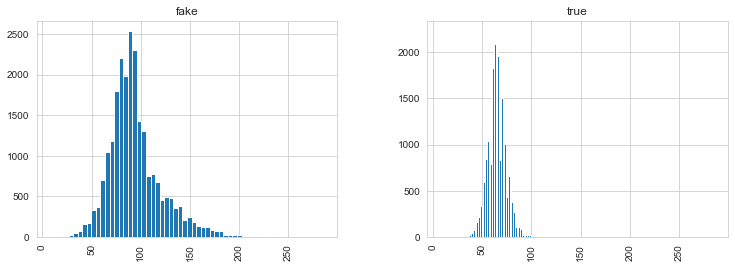

In [124]:
df2.hist(column='length',by='label',bins=60,figsize=(12,4),sharex=True);
# similar distribution

We notice that the two distributions are almost the same albeit fake news' titles seem to be longer than true ones.

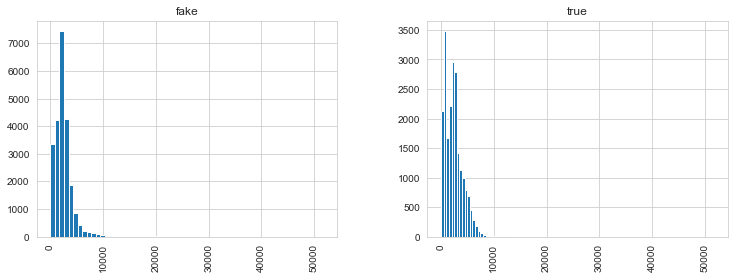

In [125]:
df2['length2'] = df2['text'].apply(len)
df2.hist(column='length2',by='label',bins=60,figsize=(12,4),sharex=True);

Idem for the title column, we notice that fake news' texts tend to be almost two times longer than the true ones.

In [126]:
df2.head()

,title,text,subject,date,label,length,length2
0,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politics,"October 18, 2016",true,32,518
1,Ted Cruz Gets Burned By Fox News Host For War...,Ted Cruz got his ass handed to him on Fox News...,News,"January 17, 2016",fake,92,4698
2,Baghdad relieved by Trump's exclusion of Iraq ...,BAGHDAD (Reuters) - Iraq expressed “deep relie...,politics,"March 6, 2017",true,61,656
3,Democratic voter-intimidation cases falter in ...,WASHINGTON (Reuters) - Democrats fell short in...,politics,"November 7, 2016",true,63,2510
4,Pence Says There Is ‘Too Much Talk’ About Rac...,"While Charlotte, North Carolina faces a state ...",News,"September 22, 2016",fake,84,1938


In [127]:
df2.drop(['length','length2'],axis=1,inplace=True)

### Encoding label

In [128]:
lb = LabelEncoder()
df2['label'] = lb.fit_transform(df2['label'])
df2.head()
# true : 1
# fake : 0

,title,text,subject,date,label
0,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politics,"October 18, 2016",1
1,Ted Cruz Gets Burned By Fox News Host For War...,Ted Cruz got his ass handed to him on Fox News...,News,"January 17, 2016",0
2,Baghdad relieved by Trump's exclusion of Iraq ...,BAGHDAD (Reuters) - Iraq expressed “deep relie...,politics,"March 6, 2017",1
3,Democratic voter-intimidation cases falter in ...,WASHINGTON (Reuters) - Democrats fell short in...,politics,"November 7, 2016",1
4,Pence Says There Is ‘Too Much Talk’ About Rac...,"While Charlotte, North Carolina faces a state ...",News,"September 22, 2016",0


In [129]:
# Get the independent features
X = df2.drop("label",axis=1)
# Get the target variable
y = df2.label

In [130]:
X.head()

,title,text,subject,date
0,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politics,"October 18, 2016"
1,Ted Cruz Gets Burned By Fox News Host For War...,Ted Cruz got his ass handed to him on Fox News...,News,"January 17, 2016"
2,Baghdad relieved by Trump's exclusion of Iraq ...,BAGHDAD (Reuters) - Iraq expressed “deep relie...,politics,"March 6, 2017"
3,Democratic voter-intimidation cases falter in ...,WASHINGTON (Reuters) - Democrats fell short in...,politics,"November 7, 2016"
4,Pence Says There Is ‘Too Much Talk’ About Rac...,"While Charlotte, North Carolina faces a state ...",News,"September 22, 2016"


In [131]:
df2.shape

(44898, 5)

In [132]:
df2 = df2.dropna()

In [133]:
data = df2.copy()

In [134]:
data.reset_index(drop=True,inplace=True)

In [135]:
data.head(10)

,title,text,subject,date,label
0,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politics,"October 18, 2016",1
1,Ted Cruz Gets Burned By Fox News Host For War...,Ted Cruz got his ass handed to him on Fox News...,News,"January 17, 2016",0
2,Baghdad relieved by Trump's exclusion of Iraq ...,BAGHDAD (Reuters) - Iraq expressed “deep relie...,politics,"March 6, 2017",1
3,Democratic voter-intimidation cases falter in ...,WASHINGTON (Reuters) - Democrats fell short in...,politics,"November 7, 2016",1
4,Pence Says There Is ‘Too Much Talk’ About Rac...,"While Charlotte, North Carolina faces a state ...",News,"September 22, 2016",0
5,EMOTIONAL TRUMP ENDORSEMENT From Former FBI As...,Former FBI Asst Director James Kallstrom endor...,Government News,"Oct 19, 2016",0
6,Ireland demands 'significantly more clarity' f...,DUBLIN/BRUSSELS (Reuters) - Ireland needs Brit...,worldnews,"November 30, 2017",1
7,CLASSIC TRUMP! President Trump Announces Where...,On the eve of the upcoming 2017 White House Co...,politics,"Apr 22, 2017",0
8,WHAT THE MEDIA’S NOT TELLING YOU About The Man...,Just another nice immigrant family trying to a...,left-news,"May 23, 2017",0
9,Czech police ask parliament to allow prosecuti...,PRAGUE (Reuters) - Czech police have requested...,worldnews,"November 21, 2017",1


### Lemmatization

In [136]:
# Text cleaning
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0,len(data)):
    review = re.sub('[^a-zA-Z]',' ',data['title'][i]) # if not in a-zA-Z, replace by blank
    review = review.lower()
    review = review.split()
    
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words("english")] # lemmatize non stopwords
    review = ' '.join(review)
    corpus.append(review)

In [137]:
vocab_size = 5000
onehot_st = [one_hot(words,vocab_size) for words in corpus] # one hot

In [138]:
# Embedding representation
sent_length = 20
embedded_docs = pad_sequences(onehot_st, padding='pre',maxlen=sent_length)
print(embedded_docs)
# adding zeros in the pre sentence in order to make the length as 20 (and 'post' to the end).

[[   0    0    0 ...  813 4166 3510]
 [   0    0    0 ... 3835  141 1189]
 [   0    0    0 ... 1930 4823 3974]
 ...
 [   0    0    0 ... 3960  360 2065]
 [   0    0    0 ... 1009 3184 1206]
 [   0    0    0 ... 1452  228  166]]


## Long short-term memory (LSTM) - Recurrent Neural Networds (RNN)

In [139]:
embedding_vector_features = 40 
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100)) # 1 LSTM with 100 neurons.
model.add(Dense(1,activation='sigmoid')) # 1 final output (classification), sigmoid (proba class 1 or class 2)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               56400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [140]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [141]:
X_train,  X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=16)

In [142]:
# Model training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
492/492 [==============================] - 11s 18ms/step - loss: 0.2394 - accuracy: 0.8974 - val_loss: 0.1636 - val_accuracy: 0.9341
Epoch 2/10
492/492 [==============================] - 8s 17ms/step - loss: 0.1351 - accuracy: 0.9464 - val_loss: 0.1581 - val_accuracy: 0.9349
Epoch 3/10
492/492 [==============================] - 8s 17ms/step - loss: 0.1024 - accuracy: 0.9607 - val_loss: 0.1571 - val_accuracy: 0.9382
Epoch 4/10
492/492 [==============================] - 8s 17ms/step - loss: 0.0744 - accuracy: 0.9726 - val_loss: 0.2020 - val_accuracy: 0.9373
Epoch 5/10
492/492 [==============================] - 9s 17ms/step - loss: 0.0549 - accuracy: 0.9797 - val_loss: 0.1972 - val_accuracy: 0.9381
Epoch 6/10
492/492 [==============================] - 9s 18ms/step - loss: 0.0398 - accuracy: 0.9861 - val_loss: 0.2525 - val_accuracy: 0.9368
Epoch 7/10
492/492 [==============================] - 9s 18ms/step - loss: 0.0289 - accuracy: 0.9891 - val_loss: 0.2839 - val_accuracy: 0.935

In [143]:
embedding_vector_features = 40 
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) # 1 LSTM with 100 neurons.
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid')) # 1 final output (classification), sigmoid (proba class 1 or class 2)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # Sigmoid + Cross-Entropy
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [144]:
y_pred = model.predict(X_test)

### Bag Of Words

In [145]:
bag_transformer = CountVectorizer(max_features=5000).fit(data['title'])

In [146]:
data_bow = bag_transformer.transform(data['title'])

In [147]:
print('Shape of Sparse Matrix: ', data_bow.shape)

Shape of Sparse Matrix:  (44898, 5000)


In [148]:
# amount of non 0 occurences
data_bow.nnz

496558

In [149]:
sparsity = (100.0*data_bow.nnz/(data_bow.shape[0]*data_bow.shape[1]))
print('sparsity: {}'.format(sparsity))
# comparison of the number of non 0 messages vs the actual number of messages.
# gives an idea of how many zeros there are in the matrix.

sparsity: 0.2211938170965299


In [150]:
## Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
# 5000 : from all the words, take the most 5000 most frequent words.
# ngram_range=(1,3) : combination of 1 word, 2 words and 3 words as a FEATURE, then apply the BOW.

In [151]:
y = data['label']

In [152]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [153]:
# combination of ngram_range=(1,3)
cv.get_feature_names()[:20]

['abadi',
 'abandon',
 'abbas',
 'abc',
 'abc news',
 'abe',
 'abedin',
 'able',
 'abortion',
 'abroad',
 'absolute',
 'absolutely',
 'abuse',
 'academic',
 'accept',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accord']

In [154]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [155]:
count_df = pd.DataFrame(X_train,columns=cv.get_feature_names())

### Confusion matrix

In [156]:
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion Matrix',
                         cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                ha="center",
                color="white" if cm[i,j]> thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### MultinomialNB Algorithm

Naive Bayes est un algorithme puissant souvent utilisé pour l'analyse de données textuelles. Le théorème de Bayes, formulé par Thomas Bayes, calcule la probabilité qu'un événement se produise sur la base de la connaissance préalable des conditions liées à un événement. Outre sa simplicité, Naïve Bayes est capable de gérer une grande quantité de données, est facile à mettre en œuvre juste en calculant la probabilité et peut être utilisé pour prédire les applications en temps réel mais ne convient pas à la régression et la précision de prédiction de cet algorithme est inférieure à celle des autres algorithmes basés sur des méthodes probabilistes.

accuracy: 0.933
Confusion matrix, without normalization


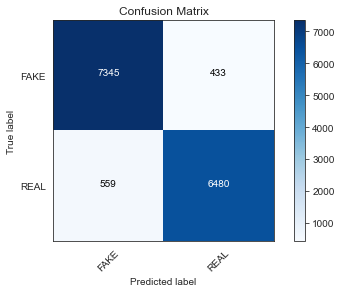

In [157]:
classifier = MultinomialNB()
sns.set_style('white')
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print("accuracy: %0.3f" % score)
cm = metrics.confusion_matrix(y_test,pred)
plot_confusion_matrix(cm, classes=['FAKE','REAL'])

In [158]:
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
score

0.9330498751434163

In [159]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7778
           1       0.94      0.92      0.93      7039

    accuracy                           0.93     14817
   macro avg       0.93      0.93      0.93     14817
weighted avg       0.93      0.93      0.93     14817



### Passive Agressive Classifier Algorithm

accuracy: 0.926
Confusion matrix, without normalization


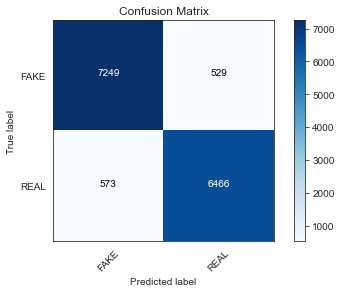

In [160]:
linear_clf = PassiveAggressiveClassifier(n_iter_no_change=50)
linear_clf.fit(X_train,y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print("accuracy: %0.3f" % score)
cm = metrics.confusion_matrix(y_test,pred)
plot_confusion_matrix(cm, classes=['FAKE','REAL'])

### Multinomial Classifier with Hyperparameter

In [161]:
classifier = MultinomialNB(alpha=0.1)
# Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)

In [162]:
previous_score = 0
for alpha in np.arange(0,1,0.1):
    sub_classifier = MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred = sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test,y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.9320375244651414
Alpha: 0.1, Score : 0.933387325369508
Alpha: 0.2, Score : 0.933589795505163
Alpha: 0.30000000000000004, Score : 0.933387325369508
Alpha: 0.4, Score : 0.9332523452790713
Alpha: 0.5, Score : 0.9334548154147263
Alpha: 0.6000000000000001, Score : 0.9333198353242896
Alpha: 0.7000000000000001, Score : 0.9333198353242896
Alpha: 0.8, Score : 0.9332523452790713
Alpha: 0.9, Score : 0.9330498751434163


In [163]:
## Get Feature names
feature_names = cv.get_feature_names()

In [164]:
classifier.coef_[0]
# most negative : most fake word
# less negative : most real word

array([ -9.20577535,  -9.61545099,  -8.74315182, ...,  -8.74315182,
       -10.32133719,  -8.04736263])

In [165]:
### Most real
sorted(zip(classifier.coef_[0],feature_names),reverse=True)[:20]

[(-3.4427466915500062, 'trump'),
 (-4.0035710026918645, 'say'),
 (-4.790789480480564, 'house'),
 (-5.213218480335952, 'russia'),
 (-5.213218480335952, 'republican'),
 (-5.216324555204642, 'north'),
 (-5.25275557164441, 'korea'),
 (-5.349211753882303, 'state'),
 (-5.359928055756661, 'new'),
 (-5.368946875906828, 'white'),
 (-5.405858244604012, 'white house'),
 (-5.43446431415029, 'china'),
 (-5.448099118291173, 'senate'),
 (-5.455974725054394, 'north korea'),
 (-5.502504153472787, 'court'),
 (-5.534059148480113, 'bill'),
 (-5.5491326466258215, 'tax'),
 (-5.586714434512294, 'election'),
 (-5.607197626748691, 'obama'),
 (-5.621089954829449, 'vote')]

In [166]:
### Most fake
sorted(zip(classifier.coef_[0],feature_names))[:5000]

[(-11.78767426201011, 'accidentally'),
 (-11.78767426201011, 'across america'),
 (-11.78767426201011, 'actual'),
 (-11.78767426201011, 'actually'),
 (-11.78767426201011, 'ad video'),
 (-11.78767426201011, 'admitting'),
 (-11.78767426201011, 'agitator'),
 (-11.78767426201011, 'al sharpton'),
 (-11.78767426201011, 'alan'),
 (-11.78767426201011, 'ali'),
 (-11.78767426201011, 'alien'),
 (-11.78767426201011, 'allegedly'),
 (-11.78767426201011, 'allen'),
 (-11.78767426201011, 'amazing'),
 (-11.78767426201011, 'america great'),
 (-11.78767426201011, 'america video'),
 (-11.78767426201011, 'american flag'),
 (-11.78767426201011, 'anderson cooper'),
 (-11.78767426201011, 'andrea'),
 (-11.78767426201011, 'angela'),
 (-11.78767426201011, 'angela merkel'),
 (-11.78767426201011, 'ann'),
 (-11.78767426201011, 'ann coulter'),
 (-11.78767426201011, 'anonymous'),
 (-11.78767426201011, 'answer question'),
 (-11.78767426201011, 'anti american'),
 (-11.78767426201011, 'anti gun'),
 (-11.78767426201011, 'a

### TF-IDF

In [167]:
tfidfv = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X = tfidfv.fit_transform(corpus).toarray()

In [168]:
tfidfv.get_feature_names()[:20]

['abadi',
 'abandon',
 'abbas',
 'abc',
 'abc news',
 'abe',
 'abedin',
 'able',
 'abortion',
 'abroad',
 'absolute',
 'absolutely',
 'abuse',
 'academic',
 'accept',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accord']

In [169]:
tfidfv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [170]:
count_df = pd.DataFrame(X_train,columns=tfidfv.get_feature_names())
count_df.head()

,abadi,abandon,abbas,abc,abc news,abe,abedin,able,abortion,abroad,...,zealand,zero,zika,zika funding,zimbabwe,zimbabwe mugabe,zone,zor,zuckerberg,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Word Cloud

In [171]:
stopwords = STOPWORDS
print(len(stopwords))

192


In [172]:
wc = WordCloud(background_color='white',stopwords=stopwords,
              height=400, width=600)

In [173]:
with open('corpus.txt', 'w') as f:
    f.write('\n'.join(corpus))

In [174]:
txt = open('corpus.txt',mode='r',encoding='utf-8').read()

In [175]:
wordcloud = wc.generate(txt)

In [176]:
#wc.to_file('wordcloud_output.png')

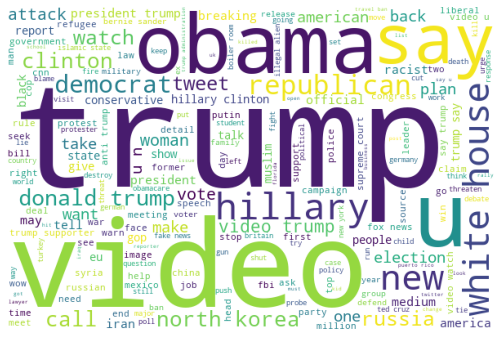

In [177]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off");
# a refaire avec la tokenization